<a href="https://colab.research.google.com/github/HawkClaws/colab_diffusers_with_civitai_checkpoint_model/blob/main/colab_diffusers_with_civitai_checkpoint_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Setup

!pip install torch==2.0.1+cu118 torchvision==0.15.2+cu118 transformers==4.32.1 diffusers==0.20.1 omegaconf==2.3.0

import torch
import diffusers
from diffusers import StableDiffusionPipeline, DPMSolverSinglestepScheduler
from pathlib import Path
from IPython.display import display
import sys
import time
import random
import uuid
import re
import requests

# MODELのダウンロードURL(例：https://civitai.com/models/36520)
MODEL_URL = "https://civitai.com/api/download/models/76907"

def setup_device():
    if torch.cuda.is_available():
        device_name = torch.device("cuda")
        torch_dtype = torch.float16
    else:
        raise Exception("GPUを選択してください")
    return device_name, torch_dtype

def download_model(model_url):
    model_path = "civitai_model.safetensors"
    with requests.get(model_url, stream=True) as response:
        with open(model_path, "wb") as file:
            for chunk in response.iter_content(chunk_size=8192):
                file.write(chunk)
    return model_path

def setup_pipeline(model_path, device_name, torch_dtype):
    pipe = StableDiffusionPipeline.from_single_file(
        model_path,
        torch_dtype=torch_dtype,
        safety_checker=None,
        use_safetensors=True
    )
    pipe.safety_checker = lambda images, **kwargs: (images, [False] * len(images))
    pipe.scheduler = DPMSolverSinglestepScheduler.from_config(pipe.scheduler.config, use_karras_sigmas=True)
    pipe = pipe.to(device_name)
    return pipe

device_name, torch_dtype = setup_device()
model_path = download_model(MODEL_URL)
pipe = setup_pipeline(model_path, device_name, torch_dtype)


  0%|          | 0/25 [00:00<?, ?it/s]

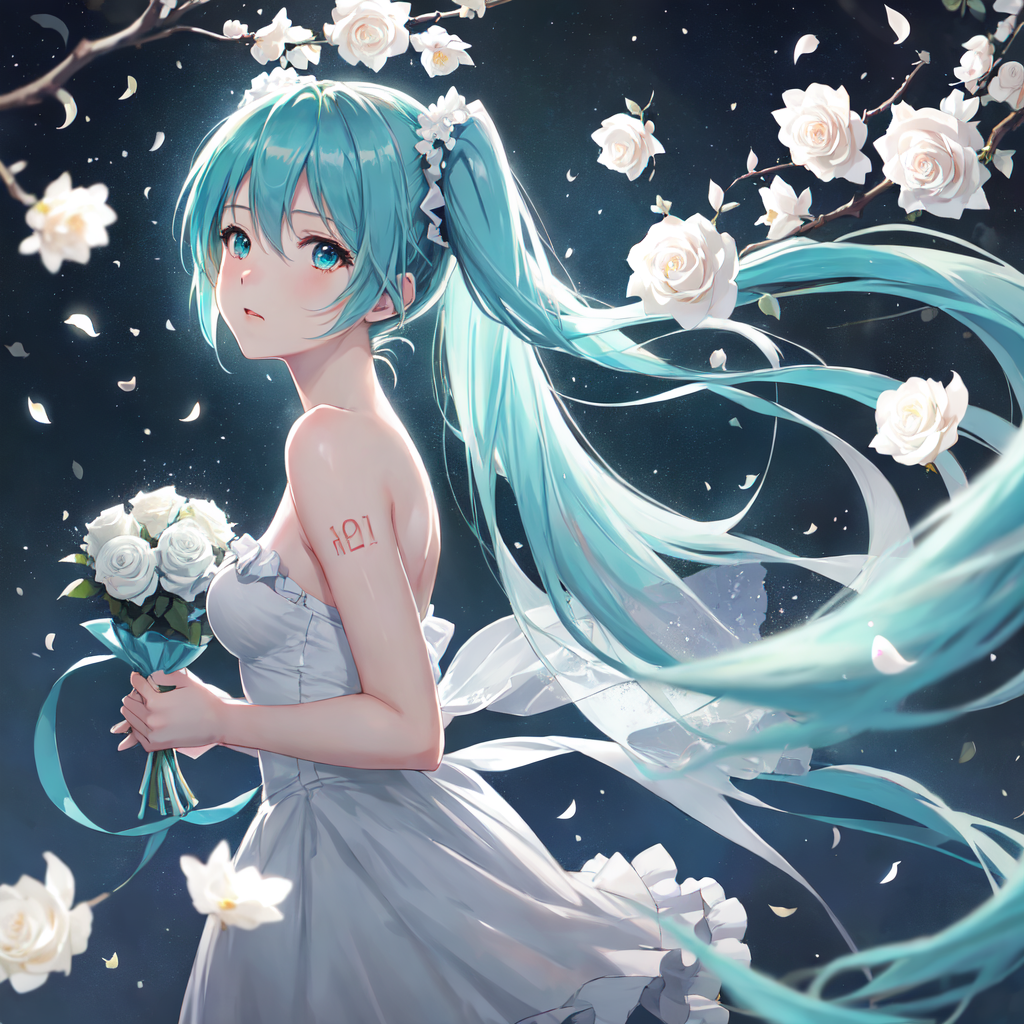

  0%|          | 0/25 [00:00<?, ?it/s]

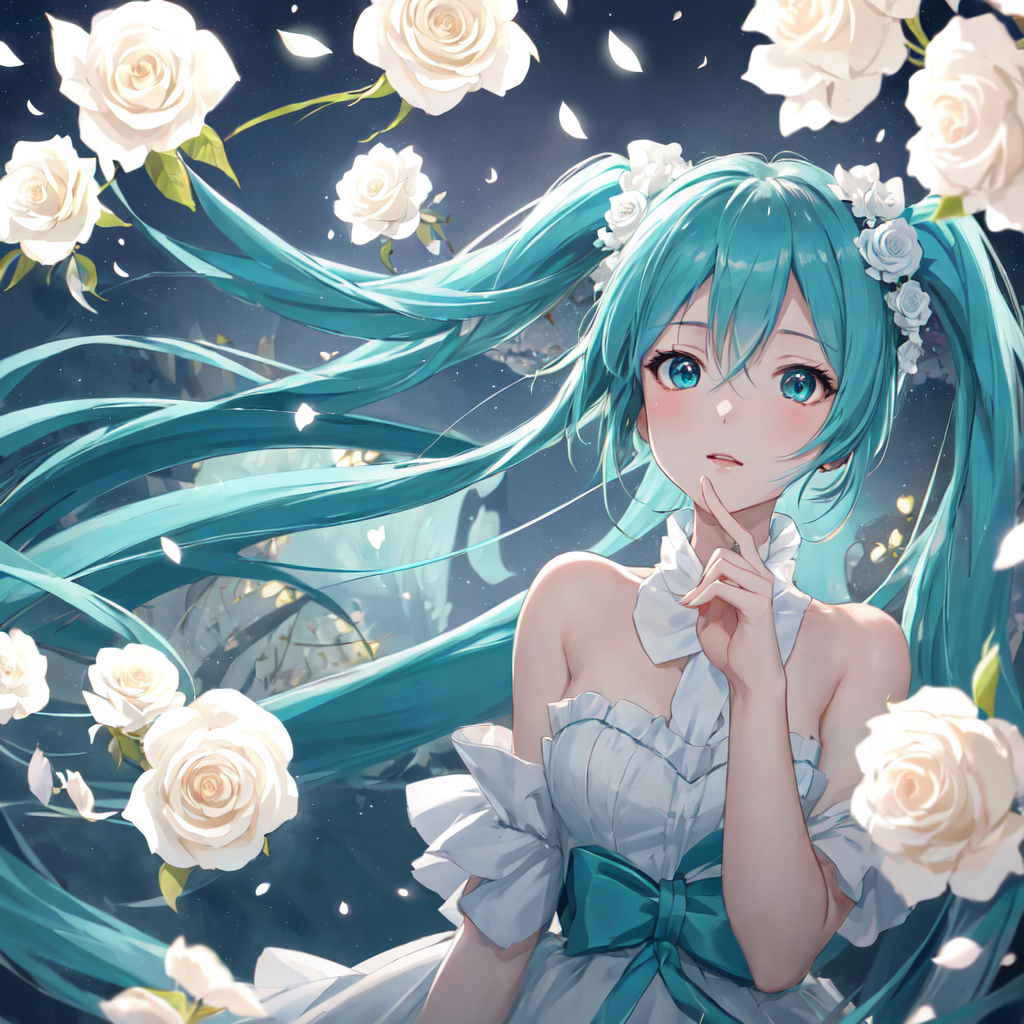

  0%|          | 0/25 [00:00<?, ?it/s]

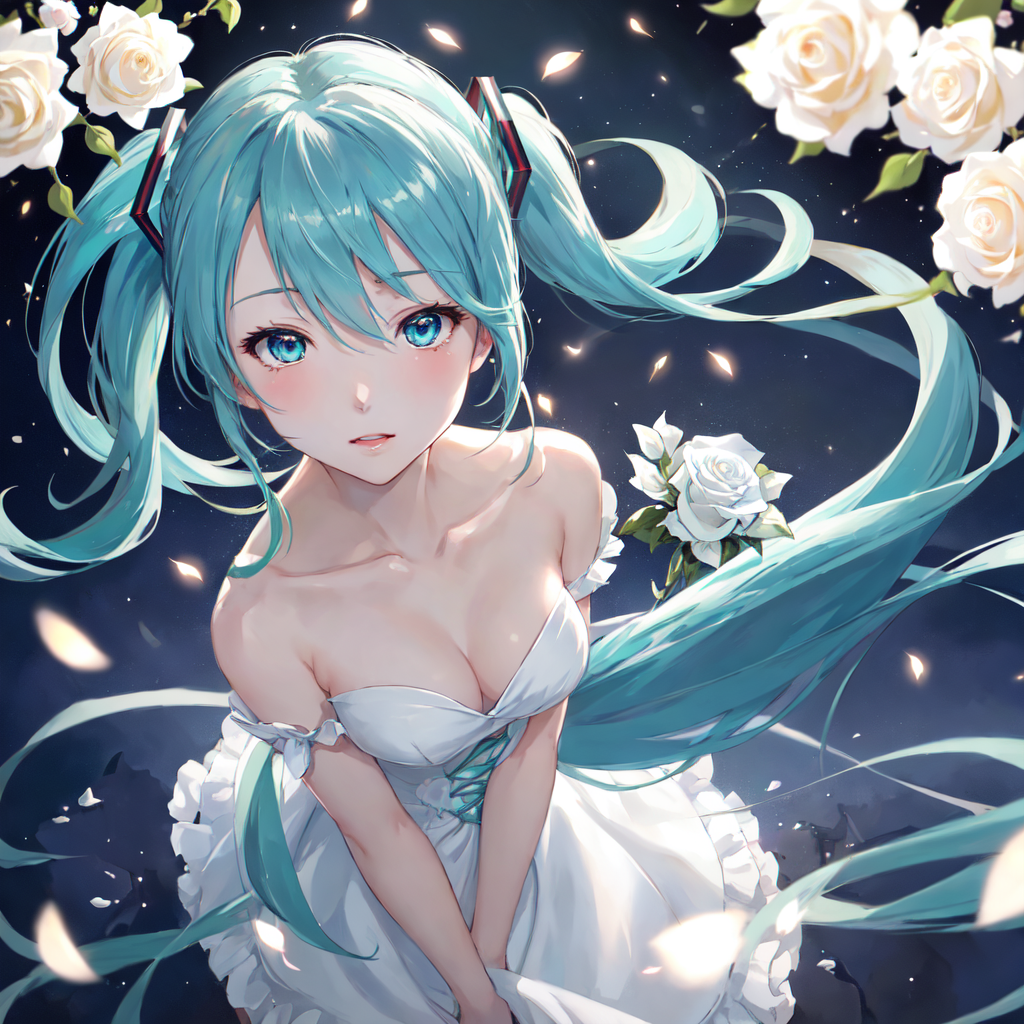

  0%|          | 0/25 [00:00<?, ?it/s]

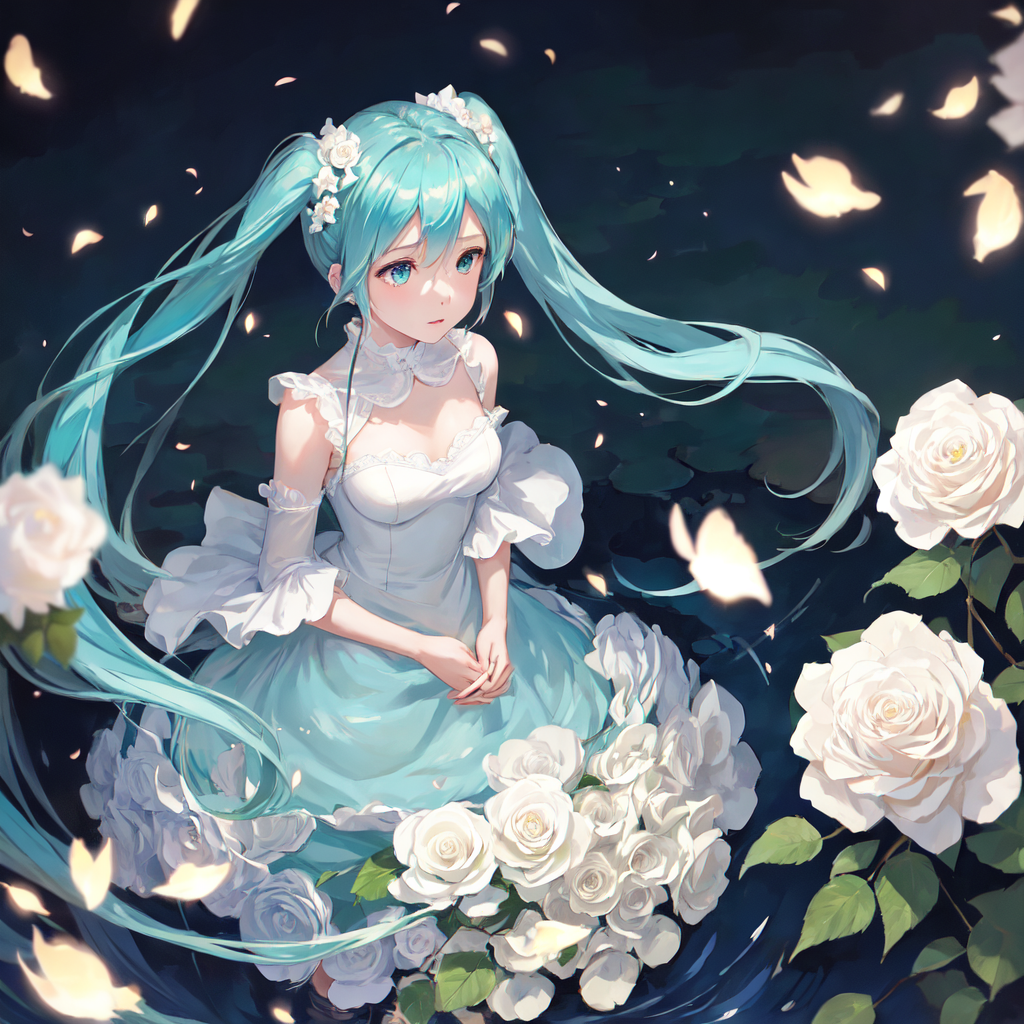

In [ ]:
#@title Generate Image

# Receive inputs using Google Colab forms
prompt = "face focus, masterpiece, best quality, 1girl, hatsune miku, white roses, petals, night background, fireflies, light particle, solo, aqua hair with twin tails, aqua eyes, standing, pixiv, depth of field, cinematic composition, best lighting, looking up"#@param {type:"string"}
negative_prompt = "(low quality, worst quality:1.2), 3d, embedding:unaestheticXLv1.safetensors, watermark, signature, ugly, poorly drawn, embedding:FastNegativeV2"#@param {type:"string"}
batch_size = 4 #@param {type:"number"}
num_inference_steps = 25 #@param {type:"number"}
guidance_scale = 9 #@param {type:"number"}
width = 1024 #@param {type:"number"}
height = 1024 #@param {type:"number"}

def generate_image(prompt, negative_prompt, width, height, guidance_scale,
                   num_inference_steps, batch_size):
    images = []
    for count in range(batch_size):
        seed = random.randint(0, sys.maxsize)
        start_time = time.time()

        new_img = pipe(
            prompt=prompt,
            negative_prompt=negative_prompt,
            width=width,
            height=height,
            guidance_scale=guidance_scale,
            num_inference_steps=num_inference_steps,
            num_images_per_prompt=1,
            generator=torch.manual_seed(seed),
        ).images

        display(*new_img)

        image_filename = str(uuid.uuid4()) + ".jpg"
        new_img[0].save(image_filename)
        images.append(new_img[0])

        elapsed_time = time.time() - start_time
        #print(f"Generated image {count + 1}/{batch_size} in {elapsed_time:.2f} seconds")

    return images

# Call the function with appropriate arguments
generated_images = generate_image(prompt, negative_prompt, width, height,
                                  guidance_scale, num_inference_steps, batch_size)
